# Building a Convolutional Neural Net with Keras & Tensorflow

This tutorial demonstrates how to build a deep Convolutional Neural Network for image classification with Keras on a Tensorflow backend using the 
[CIFAR-10 dataset](http://www.cs.toronto.edu/~kriz/cifar.html) -  
It will also demonstrate how easily Tensorboard can be utilized with Keras.

This notebook is intended to be run on [Google Cloud Datalab](https://cloud.google.com/datalab/)

Datalab will have the required libraries installed by default for this code to work. If you choose to run this code outside of Datalab you may run in to version and dependency issues which you will need to resolve.

In [2]:
from __future__ import division
from __future__ import print_function

import tensorflow as tf
#from tensorflow import keras
!pip3 install keras
from tensorflow.python.keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

    100% |████████████████████████████████| 307kB 14.9MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 21.5MB/s ta 0:00:01


Using TensorFlow backend.


In [3]:
"""Loads CIFAR10 dataset.
  Returns:
      Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
      Source: https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/python/keras/datasets/cifar10.py
  """

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [17]:
# Defining class names and how many there are
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = 10

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


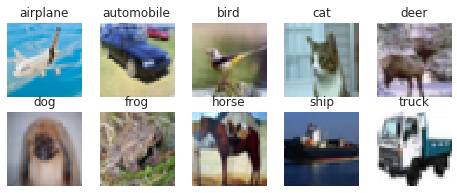

In [5]:
# Checking dataset and printing figures of 10 random images from each class
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num,::],(0,1,2))
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [6]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


## Create the Model

Start building the convnet using Keras' [Sequential Model API](https://keras.io/models/sequential/) by 'stacking up' the layers.

In [18]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Setting up Tensorboard

In [8]:
# Instatiating Keras' Tensorboard class with all the parts we want to have included; this will be added into .fit-methods callback for training
tensorboard = TensorBoard(
    log_dir='./logs',#{}.format('cnn'),
    write_graph=True,
    write_grads=True,
    histogram_freq=1,
    write_images=True,
)

The following code will instatiate TensorBoard and provide a link to access it.

In [13]:
from google.datalab.ml import TensorBoard
TensorBoard().start('./logs')

TensorBoard was started successfully with pid 24509. Click here to access it.

24509

The following code will stop Tensorboard - RUN ONLY IF YOU WANT TO CLOSE IT!!

In [11]:
for pid in TensorBoard.list()['pid']:
  TensorBoard().stop(pid)

# Compile and Train the Model

In [9]:
# Let's compile the model using Adam Optimizer incl. a learning rate + decay
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001,decay=1e-6),
              metrics=['accuracy'])

# Let's normalize the features
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [14]:
# Let's train the model
model.fit(x_train, y_train,
              batch_size=128,
              epochs=5,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=[tensorboard])

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 11s 213us/step - loss: 0.9414 - acc: 0.6696 - val_loss: 0.8199 - val_acc: 0.7186
Epoch 2/5
50000/50000 [==============================] - 10s 209us/step - loss: 0.8477 - acc: 0.7029 - val_loss: 0.7659 - val_acc: 0.7352
Epoch 3/5
50000/50000 [==============================] - 10s 209us/step - loss: 0.7870 - acc: 0.7245 - val_loss: 0.7445 - val_acc: 0.7405
Epoch 4/5
50000/50000 [==============================] - 11s 210us/step - loss: 0.7354 - acc: 0.7412 - val_loss: 0.6976 - val_acc: 0.7581
Epoch 5/5
50000/50000 [==============================] - 10s 209us/step - loss: 0.6939 - acc: 0.7565 - val_loss: 0.6655 - val_acc: 0.7676


# Test the Model

In [16]:
score = model.evaluate(x_test, y_test, verbose=0)

print('test loss: {:.4f}'.format(score[0]))
print(' test acc: {:.4f}'.format(score[1]))

test loss: 0.6655
 test acc: 0.7676
